In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-06-MACHINE-LEARNING-II/master/init.py
import init; init.init(force_download=False); 

# Demanda de Bicicletas Públicas

En esta ocasión vamos a tratar de predecir la cantidad de bicicletas requeridas en un sistema de bicicletas públicas. A continuación encontramos la descripción tomada de la fuente original.


## Background 

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.


## Data Set

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 


## Associated tasks

	- Regression: 
		Predication of bike rental count hourly based on the environmental and seasonal settings.
	

## Dataset characteristics

`data.csv` has the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    
    
Puedes agregar cualquier función, clase, módulo o paquete que creas necesario.

OJO NO SE PUEDE EJECUTAR TODO EL NOTEBOOK CON RUN ALL, es necesario instalar  

In [ ]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [ ]:
df = pd.read_csv("local/data/timeseries.csv")
df.head()

instant      dteday  season  yr  ...  windspeed  casual  registered  cnt
0        1  2011-01-01       1   0  ...        0.0       3          13   16
1        2  2011-01-01       1   0  ...        0.0       8          32   40
2        3  2011-01-01       1   0  ...        0.0       5          27   32
3        4  2011-01-01       1   0  ...        0.0       3          10   13
4        5  2011-01-01       1   0  ...        0.0       0           1    1

[5 rows x 17 columns]

Primero lo primero, vamos a separar los features de la variable que queremos predecir.

In [ ]:
target_column = "cnt"
y = df[target_column]
X = df

Lo segundo es separar los datos en entrenamiento y prueba

In [ ]:
train_indices = X["yr"] == 0
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[~train_indices], y[~train_indices]

In [ ]:
assert X.shape[0] == X_train.shape[0] + X_test.shape[0]

Lo último antes de empezar a hacer modelos es definir la métrica con que vamos a medir la calidad de nuestros modelos. Es importante considerar los tipos de erorr que podemos cometer. En este caso, podríamos equivocarnos porque nuestro modelo predice más demanda de la real o porque predice menos. En la vida real, hay un tipo de error que duele más, un tipo de error que cuesta más; cuál es este error depende del caso de uso, hay que mirar todos los costos asociados. 

En este caso, tendríamos que considerar el costo que representa para la empresa tener una bicicleta parqueada (por ejemplo, más espacios y transporte) y el precio en el que incurre la empresa al no tener una bicicleta disponible.

In [ ]:
def bike_number_error(y_true, y_pred, understock_price=0.3, overstock_price=0.7):
  error = y_true - y_pred
  return sum(map(lambda err: overstock_price*err*(-1) if err < 0 else understock_price*err , error)) / len(error)

In [ ]:
bike_number_error(np.array([5, 6, 7]), np.array([6, 5, 7]) )

0.3333333333333333

Bajo la consideración que el espacio en Washinton ronda desde 2100 hasta 3600 dolares el metro cuadrado. Supongo que el dinero invertido en el almacenamiento, mantenimiento y gestión de las bicicletas genera un impacto peor en la ecónomia de la empresa. Lo cual en un plan de expansión como el propuesto por la compañia implicaría grandes perdidas.

## Baseline

¿Cuál es la predicción más sencilla que puedes hacer?

Se propone revisar los promedios de los datos agrupando por semana y día para retornar el valor promedio según la entrada recibida. Es decir, según la entrada que nos indica el nuevo dato, se buscara en un arreglo definido en el fit, cual es el promedio para un día X con una semana Y y ese será el valor asignado.

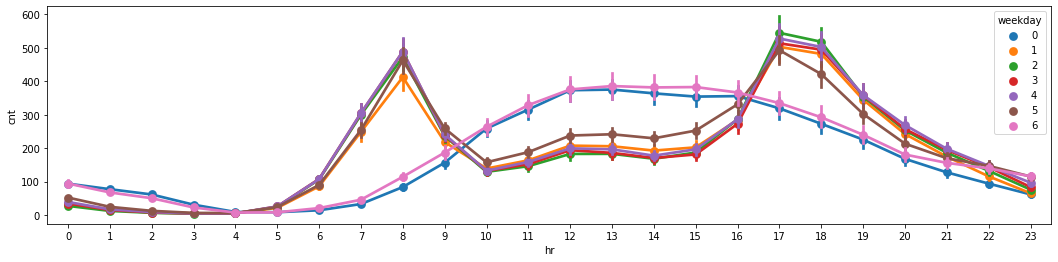

In [ ]:
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

sns.pointplot(data=df, x="hr", y="cnt", hue="weekday", ax=ax1)

In [ ]:
class BaselineBkieRentalForecaster(BaseEstimator, RegressorMixin):
  def __init__(self, hr_col=5, weekday_col=7):
    self.hr_col = hr_col
    self.weekday_col = weekday_col
  def fit(self, X, y=None):
    temp = X.copy()
    temp["cnt"] = y
    data = temp.groupby(["hr", "weekday"])["cnt"].mean().reset_index()
    for i in range(7):
      for j in range(24):
        if data[(data["hr"] == j) & (data["weekday"] == i)].empty:
          data = data.append({'hr': j, 'weekday': i, 'cnt': data ["cnt"].mean()}, ignore_index=True)
    self.computed = data
    return self
  def predict(self, X):
    temp = X.copy()
    return list(map(lambda x: self.computed.loc[ (self.computed["hr"] == x[self.hr_col]) & (self.computed["weekday"] == x[self.weekday_col])]["cnt"].values[0] , temp.values))


In [ ]:
class FeatureDroppedHelper(BaseEstimator, TransformerMixin):
  def __init__(self, selected_features):
    self.selected_features = selected_features
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X_temp = X.copy()
    return X_temp.drop(columns=self.selected_features)

In [ ]:
class FeatureSelectHelper(BaseEstimator, TransformerMixin):
  def __init__(self, selected_features):
    self.selected_features = selected_features
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X_temp = X.copy()
    return X_temp[self.selected_features]

In [ ]:
baseline = Pipeline([
    ('selector', FeatureSelectHelper(["season", "yr", "mnth" ,"hr","holiday","weekday","workingday","weathersit","temp","atemp","hum","windspeed"])),
    ('model', BaselineBkieRentalForecaster(hr_col=3, weekday_col=5))
])

Ahora entrena y calcula el error de este modelo, requreda que no debes usar los datos de prueba sino hasta final de todo el proceso, entonces quizá debas partir de nuevo los datos de entrenamiento.

Despues de múltiples pruebas encontramos que este modelo funciona mejor sin FeatureSelectHelper

### Evaluación del modelo

### Validación cruzada

In [ ]:
scorer = make_scorer(bike_number_error, understock_price=0.3, overstock_price=0.7)

In [ ]:
time_series_splitter = TimeSeriesSplit(n_splits=4)

In [ ]:
cross_validate(baseline, X_train, y_train, scoring=scorer, cv=time_series_splitter)

{'fit_time': array([0.13791251, 0.11585522, 0.11553717, 0.11691952]),
 'score_time': array([1.33119202, 1.37287164, 1.28734517, 1.2981236 ]),
 'test_score': array([25.59141044, 27.14570498, 22.33964778, 22.90983287])}

In [ ]:
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 36.043375277784676


## Comparación con el modelo presentado en clase.

In [ ]:
class BaselineBkieRentalForecaster2(BaseEstimator, RegressorMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    temp = X.copy()
    return np.ones(X.shape[0])*10

In [ ]:
baseline_class = Pipeline([
    ('selector', FeatureSelectHelper(["season", "yr", "mnth" ,"hr","holiday","weekday","workingday","weathersit","temp","atemp","hum","windspeed"])),
    ('model', BaselineBkieRentalForecaster2())
])

In [ ]:
cross_validate(baseline_class, X, y, scoring=scorer, cv=time_series_splitter)

{'fit_time': array([0.00529885, 0.0051167 , 0.00405335, 0.0042212 ]),
 'score_time': array([0.00426698, 0.00373793, 0.00251079, 0.00234008]),
 'test_score': array([53.17956835, 40.17700719, 76.59415827, 71.96126619])}

In [ ]:
baseline_class.fit(X_train, y_train)
y_pred = baseline_class.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 67.83212731852524


Se pueden observar los siguientes resultados:

- Los errores presentados por el método proporcionado de manera heuristica por el docente son mejores que los implementados mediante un algortimo más complejo, esto puede apreciarse en la válidación cruzada.
- Cuando se entrenan con la separación por años el modelo que obtiene la media por semana y hora tiende a tener un mejor desempeño. Este comportamiento se debe a que la validación cruzada es una estimación más robusta.
- El tiempo de ejecución para el módelo con medias es mucho mayor que la implementación realizada en clase.

- Normalmente como ingenieros tendemos a tratar de generar capas de complejidad para los problemas que algunas veces no implican mejores resultados. Es necesario crear una balance entre la implementación de modelos de alta calidad y métricas heurísticas que provienen del cliente.
- Siempre es necesario validar las métricas con el cliente dado que como ingenieros de machine learning NO SOMOS EXPERTOS en el negocio.


## Baseline 2.0

Las librerías actuales permiten que entrenar modelos que suelen funcionar bien sea realtivamente fácil. Por esto, escoge un modelo en con el cual sea fácil de trabajar, que no tengas que hacer mucho preprocesamiento. 

In [ ]:
X_train

instant      dteday  season  yr  ...  windspeed  casual  registered  cnt
0           1  2011-01-01       1   0  ...     0.0000       3          13   16
1           2  2011-01-01       1   0  ...     0.0000       8          32   40
2           3  2011-01-01       1   0  ...     0.0000       5          27   32
3           4  2011-01-01       1   0  ...     0.0000       3          10   13
4           5  2011-01-01       1   0  ...     0.0000       0           1    1
...       ...         ...     ...  ..  ...        ...     ...         ...  ...
8640     8641  2011-12-31       1   0  ...     0.2239      19          73   92
8641     8642  2011-12-31       1   0  ...     0.2239       8          63   71
8642     8643  2011-12-31       1   0  ...     0.1940       2          50   52
8643     8644  2011-12-31       1   0  ...     0.1343       2          36   38
8644     8645  2011-12-31       1   0  ...     0.0000       4          27   31

[8645 rows x 17 columns]

In [ ]:
baseline_2 = Pipeline([
    ('selector', FeatureSelectHelper(["season", "yr", "mnth" ,"hr","holiday","weekday","workingday","weathersit","temp","atemp","hum","windspeed"])),
    ("scaler", StandardScaler()),
    ("regression", RandomForestRegressor())
])

No hace falta que lo entrenes utilizando *Grid Search*, después de todo, es un baseline. 

In [ ]:
cross_validate(baseline_2, X_train, y_train, scoring=scorer, cv=time_series_splitter)

{'fit_time': array([0.64534712, 1.23724699, 1.87312889, 2.58908153]),
 'score_time': array([0.02680779, 0.02668786, 0.0392065 , 0.03631043]),
 'test_score': array([18.80157085, 17.68648178, 16.45462724, 19.11923308])}

In [ ]:
baseline_2.fit(X_train, y_train)
y_pred = baseline_2.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 27.690746748339762


El modelo basado en observaciones heuristicas (devolver 10 a todo) sigue presentando mejores resultados en la validación cruzada que cualquierda de las implementaciones simples que hemos realizado hasta el momento.

Para el caso del modelo RandomForest existen varias razones por las cuales se presento un rendimiento muy malo, una de estás razones podría ser que las variables categoricas no se encuentran códificadas.

In [ ]:
model = Pipeline([
    ('selector', FeatureSelectHelper(["season", "yr", "mnth" ,"hr","holiday","weekday","workingday","weathersit","temp","atemp","hum","windspeed"])),
    ("encoder", ColumnTransformer(
        transformers=[('encode_categotical', OneHotEncoder(handle_unknown = 'ignore'), [0,2,3,4,5,6,7])],
         remainder='passthrough'
    )),
    ("scaler", StandardScaler(with_mean=False)),
    ("regression", RandomForestRegressor())
])

In [ ]:
cross_validate(model, X_train, y_train, scoring=scorer, cv=time_series_splitter)

{'fit_time': array([ 3.0574038 ,  8.83540893, 16.24284101, 24.5933249 ]),
 'score_time': array([0.03952241, 0.03385758, 0.04722261, 0.04768085]),
 'test_score': array([25.1926738 , 40.67665587, 17.95985033, 17.50206998])}

In [ ]:
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 29.380449995365634


Realizar OneHotEncoding mejoro el rendimiento validación cruzado, sin embargo, no fue un aumento considerable y el tiempo de ejecución es mucho mayor.

## Feature Engineering

Ahora, llego la hora de sacar provecho de la serie de tiempo, crea las características que creas relevantes en el caso de uso actual.

Para esta etapa usaremos la librería recomendada en clase ts_fresh, pero con el tranformer enfocado en sklearn RelevantFeatureAugmenter.

Ahora entrena un modelo que saque provecho de esto (también puedes añadir muchos más pasos de extración de características, te aseguro que te hará falta algo para limpiar los datos de valores nulos ¿por qué?). Puedes tener los hiperparámetros que quieras y usar el método de regresión que quieras, pero la creación de tu modelo va a parecerse a lo siguiente:

```python
model = Pipeline([
    ("extractor", BikeRentalFeatureExtractor())
    ("regressor", RandomForestRegressor())
])
```

Esta vez si debes usar *Grid Search*, asegúrate de hacer validación cruzada partiendo los datos de la forma apropiada para series de tiempo. 

### ¿Por qué se deben imputar los valores nulos en una serie de tiempo?

Se deben encontrar los valores nulos dentro los registros de la serie de tiempo para poder mantener el orden correcto dentro de los índices, de tal manera, que el modelo pueda seguir correctamente los patrones pertenecientes a la serie de tiempo. 

### Modelo

Tal como lo indica el punto comenzaremos con la revisión de los datos y trataremos de identificar los posibles valores nulos que presente.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

¿Cuantos registros deberiamos tener?

Dado que el dataset expresa los registros de 2 años, con resgitros durante cada hora del día. Tenemos que la expresión de registros total es: 365dias * 24horas * 2años



Es de resaltar que el año 2012 fue biciesto, por ende se deben sumar 24 horas del 29 de febrero.

In [ ]:
((365 * 24 * 2 ) + 24) - df.shape[0]

165

Podemos ver que faltan 165 registros. Para poder solucionar dicho inconveniente primero debemos identificar cuales son los registros temporales faltantes y definir una estrategía de imputación.

In [ ]:
df['datetime'] =  pd.to_datetime(df['dteday']) + df['hr'].apply(pd.Timedelta, unit='h')

In [ ]:
df.head()

instant      dteday  season  yr  ...  casual  registered  cnt            datetime
0        1  2011-01-01       1   0  ...       3          13   16 2011-01-01 00:00:00
1        2  2011-01-01       1   0  ...       8          32   40 2011-01-01 01:00:00
2        3  2011-01-01       1   0  ...       5          27   32 2011-01-01 02:00:00
3        4  2011-01-01       1   0  ...       3          10   13 2011-01-01 03:00:00
4        5  2011-01-01       1   0  ...       0           1    1 2011-01-01 04:00:00

[5 rows x 18 columns]

In [ ]:
df_time = df.set_index('datetime')
df_time = df_time.reindex(pd.date_range(
        start=df_time.index[0],
        end=df_time.index[-1],
        freq='1H'
    )
)
df_time.head()

instant      dteday  season  ...  casual  registered   cnt
2011-01-01 00:00:00      1.0  2011-01-01     1.0  ...     3.0        13.0  16.0
2011-01-01 01:00:00      2.0  2011-01-01     1.0  ...     8.0        32.0  40.0
2011-01-01 02:00:00      3.0  2011-01-01     1.0  ...     5.0        27.0  32.0
2011-01-01 03:00:00      4.0  2011-01-01     1.0  ...     3.0        10.0  13.0
2011-01-01 04:00:00      5.0  2011-01-01     1.0  ...     0.0         1.0   1.0

[5 rows x 17 columns]

In [ ]:
assert ((365 * 24 * 2 ) + 24) == df_time.shape[0]

In [ ]:
df_time[df_time.isna()].head()

instant dteday  season  ...  casual  registered  cnt
2011-01-01 00:00:00      NaN    NaN     NaN  ...     NaN         NaN  NaN
2011-01-01 01:00:00      NaN    NaN     NaN  ...     NaN         NaN  NaN
2011-01-01 02:00:00      NaN    NaN     NaN  ...     NaN         NaN  NaN
2011-01-01 03:00:00      NaN    NaN     NaN  ...     NaN         NaN  NaN
2011-01-01 04:00:00      NaN    NaN     NaN  ...     NaN         NaN  NaN

[5 rows x 17 columns]

In [ ]:
df_time.isna().sum()

instant       165
dteday        165
season        165
yr            165
mnth          165
hr            165
holiday       165
weekday       165
workingday    165
weathersit    165
temp          165
atemp         165
hum           165
windspeed     165
casual        165
registered    165
cnt           165
dtype: int64

### ¿Cómo imputar los datos nulos?



Ahora que se encontraron los registros nulos, es necesario procesar dicha información para darle valores cohorentes que nos permita  entrenar de una mejor manera el modelo.

Las consideraciones necesarias para realizar este proceso de imputación son:

- Los datos hora, dia de la semana, mes y año se obtendran del objeto índice.
- El valor de holyday se asignará a 0 porque ninguna de las fechas nulas coincide con un gestivo américano.
- El valor workingday será 1, si el día de la semana está en un rango entre 0 y 4.
- La temporada se obtendra de acuerdo al día y al mes del año.
- weathersit será asignada de manera aleatoria, debido a que no existe una relación clara entre el estado del clima y un día en particular.
- Las demás variables se obtendran mediante una interpolación del tipo time, implementada mediante pandas.

In [ ]:
df_imp = df_time.drop(columns=['dteday', 'instant'])

In [ ]:
from random import seed
from random import randint
from datetime import date, datetime
import holidays

seed(1)

null_indexes = df_imp[df_imp.isna().any(axis=1)].index

Y = 2000
seasons = [(1, (date(Y,  1, 1),  date(Y,  6, 20))),
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),
           (4, (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

for index in null_indexes:
  df_imp.loc[index, ['hr', 'yr', 'mnth']] = (index.hour, int(index.year == 2012), index.month)
  df_imp.holiday.loc[index] = int(index in holidays.UnitedStates())
  df_imp.weekday.loc[index]  = index.dayofweek
  df_imp.workingday.loc[index]  = int(index.dayofweek in [0,1,2,3,4])
  df_imp.season.loc[index]  = get_season(index)
  df_imp.weathersit.loc[index]  = randint(1, 4)

df_imp.temp = df_imp.temp.interpolate(method='time')
df_imp.atemp = df_imp.atemp.interpolate(method='time')
df_imp.hum = df_imp.hum.interpolate(method='time')
df_imp.windspeed = df_imp.windspeed.interpolate(method='time')
df_imp.casual = df_imp.casual.interpolate(method='time').apply(np.floor)
df_imp.registered = df_imp.registered.interpolate(method='time').apply(np.floor)

df_imp.cnt =  df_imp.casual + df_imp.registered

In [ ]:
df_imp.shape

(17544, 15)

In [ ]:
df_imp.isna().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
df_imp.yr = df_imp.yr.astype(np.int64)
df_imp.mnth = df_imp.mnth.astype(np.int64)
df_imp.hr = df_imp.hr.astype(np.int64)
df_imp.season = df_imp.season.astype(np.int64)
df_imp.holiday = df_imp.holiday.astype(np.int64)
df_imp.weekday = df_imp.weekday.astype(np.int64)
df_imp.workingday = df_imp.workingday.astype(np.int64)
df_imp.weathersit = df_imp.weathersit.astype(np.int64)

In [ ]:
df_imp

season  yr  mnth  hr  ...  windspeed  casual  registered    cnt
2011-01-01 00:00:00       1   0     1   0  ...     0.0000     3.0        13.0   16.0
2011-01-01 01:00:00       1   0     1   1  ...     0.0000     8.0        32.0   40.0
2011-01-01 02:00:00       1   0     1   2  ...     0.0000     5.0        27.0   32.0
2011-01-01 03:00:00       1   0     1   3  ...     0.0000     3.0        10.0   13.0
2011-01-01 04:00:00       1   0     1   4  ...     0.0000     0.0         1.0    1.0
...                     ...  ..   ...  ..  ...        ...     ...         ...    ...
2012-12-31 19:00:00       1   1    12  19  ...     0.1642    11.0       108.0  119.0
2012-12-31 20:00:00       1   1    12  20  ...     0.1642     8.0        81.0   89.0
2012-12-31 21:00:00       1   1    12  21  ...     0.1642     7.0        83.0   90.0
2012-12-31 22:00:00       1   1    12  22  ...     0.1343    13.0        48.0   61.0
2012-12-31 23:00:00       1   1    12  23  ...     0.1343    12.0        37.0   49.0

[17544 rows x 15 columns]

### Contrucción del pipeline y extractor de caracteristicas

In [ ]:
from datetime import timedelta

class FeatureEngineering(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def extract_past_y(self):
    start = self.new_features.index[0]
    last = self.new_features.index[-1] - timedelta(hours=1)
    values = np.concatenate(
        (self.new_features.loc[:start, 'cnt'].values,
        self.new_features.loc[:last, 'cnt'].values)
    )
    self.new_features['past_y'] = values
  def rolling_mean(self):
    self.new_features['SMA_cnt_30'] = self.new_features.cnt.rolling(30,center=True,min_periods=1).mean()
    self.new_features['SMA_cnt_60'] = self.new_features.cnt.rolling(60,center=True,min_periods=1).mean()
  def rolling_median(self):
    self.new_features['median_cnt_30'] = self.new_features.cnt.rolling(10,center=True,min_periods=1).median()
    self.new_features['median_cnt_15'] = self.new_features.cnt.rolling(20,center=True,min_periods=1).median()
  def last_day(self):
    second_day_start = self.new_features.index[0] + timedelta(hours=23)
    last_day_start = self.new_features.index[-1] - timedelta(days=1)
    values = np.concatenate(
        (self.new_features.loc[:second_day_start,'cnt'].values,
        self.new_features.loc[:last_day_start,'cnt'].values)
    )
    self.new_features['last_day_same_hour'] = values
  def transform(self, X):
    self.new_features = X.copy()
    self.extract_past_y()
    return self.new_features

In [ ]:
final_model = Pipeline([
    ("extractor", FeatureEngineering()),
    ("helper", FeatureDroppedHelper(['registered', 'casual','cnt']) ),
    ("scaler", StandardScaler()),
    ("regression", RandomForestRegressor())
])

In [ ]:
train_indices = df_imp["yr"] == 0
X = df_imp
y = df_imp["cnt"]

X_train, y_train = df_imp[train_indices], y[train_indices]
X_test, y_test = df_imp[~train_indices], y[~train_indices]

Realizamos una preducción inicial para identificar a grandes rasgos como se comporta nuestro sistema

In [ ]:
final_model.fit(X_train, y_train)
y_pred= final_model.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 18.166211293260424


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, final_model.predict(X_train))
mae_test = mean_absolute_error(y_test, final_model.predict(X_test))

msg = "Error de entrenamiento: {}\nError de prueba: {}"
print(msg.format(mae_train, mae_test))

Error de entrenamiento: 6.319114155251142
Error de prueba: 52.03823315118397


Comenzamos el proceso de búsqueda para encontrar el modelo con los mejores parámetros. En este caso usamos GridSearchCV para iterar sobre las diferentes combinaciones de parámetros de tal forma que sea posible identificar la mejor predicción.

In [ ]:
parameters = {
    'regression__n_estimators': [6, 20, 60, 100],
    'regression__max_depth': [10, 33, 10, 60]
}

grid_search = GridSearchCV(
    estimator=final_model,
    param_grid=parameters,
    cv=time_series_splitter,
    scoring=scorer,
    verbose=4,
    n_jobs=-1
)

In [ ]:
gs = grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   39.3s finished


In [ ]:
print("Best parameter (CV score=%0.3f):" % gs.best_score_)
print(gs.best_estimator_)

Best parameter (CV score=14.322):
Pipeline(memory=None,
         steps=[('extractor', FeatureEngineering()),
                ('helper',
                 FeatureDroppedHelper(selected_features=['registered', 'casual',
                                                         'cnt'])),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regression',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=60,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                         

In [ ]:
best_model = gs.best_estimator_

In [ ]:
gs.best_params_

{'regression__max_depth': 60, 'regression__n_estimators': 6}

In [ ]:
best_model.fit(X_train, y_train)
y_pred= best_model.predict(X_test)

err = bike_number_error(y_test, y_pred)
print(f"Error custom {err}")

Error custom 19.00836938372811


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, best_model.predict(X_train))
mae_test = mean_absolute_error(y_test, best_model.predict(X_test))

msg = "Error de entrenamiento: {}\nError de prueba: {}"
print(msg.format(mae_train, mae_test))

Error de entrenamiento: 7.6234398782344
Error de prueba: 53.17526183970857


## Error Analysis

¿Qué tipo de errores comete el modelo? ¿Se equivoca más unos días que otros? ¿Cómo podemos mejorar nuestro proceso para cometer menos errores en esos dias? 

Puedes responder con texto, pero sería genial si se te ocurre una solución que puedas aplicar tus ideas para mejorar el modelo.

In [ ]:
final_data = X_test.copy()
final_data['y_pred'] = y_pred
final_data['err'] = np.abs(y_test - y_pred)
final_data.head()

season  yr  mnth  ...   cnt     y_pred        err
2012-01-01 00:00:00       1   1     1  ...  48.0  39.166667   8.833333
2012-01-01 01:00:00       1   1     1  ...  93.0  36.833333  56.166667
2012-01-01 02:00:00       1   1     1  ...  75.0  66.500000   8.500000
2012-01-01 03:00:00       1   1     1  ...  52.0  50.833333   1.166667
2012-01-01 04:00:00       1   1     1  ...   8.0   9.000000   1.000000

[5 rows x 17 columns]

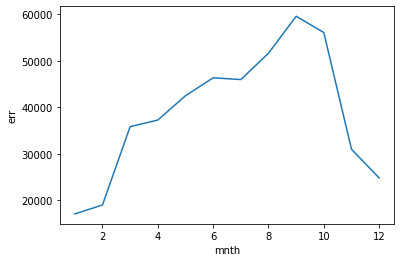

In [ ]:
group_by_mnth = final_data.groupby(by=['mnth']).sum()
sns.lineplot(x=group_by_mnth.index, y=group_by_mnth.err)

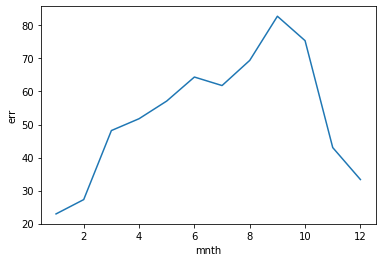

In [ ]:
group_by_mnth = final_data.groupby(by=['mnth']).mean()
sns.lineplot(x=group_by_mnth.index, y=group_by_mnth.err)

El mes donde el modelo presenta el mayor error es en septiembre, y el mes donde el sistema presenta menor error es enero.

### ¿Donde se equivoca el modelo?

El modelo se equivoca principalmente en aquellos valores limite que parecen no coincidir con la progresión, podriamos llamar a estos valores dificilmente predecibles, pues entre en 2012 y el 2011 los valores para los picos son bastante diferentes y causan que el modelo no logre adaptarse fácilmente. Otro factor de error que pudo generarse por una medida incorrecta o simplemente por errores en los datos recide en los datos captados entre noviembre y diciembre de 2012 en uso de bicicletas bajo considerablemente y afecta la progresión de tiempo.

### ¿En que días se equivoca más?

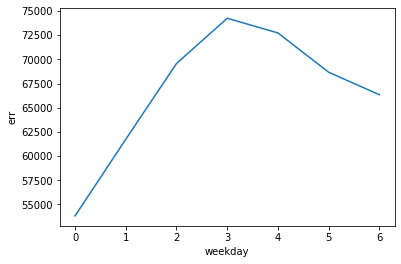

In [ ]:
group_by_day = final_data.groupby(by=['weekday']).sum()
sns.lineplot(x=group_by_day.index, y=group_by_day.err)

El día donde se presentan menor errores es el lunes y el día donde se presenta más errores es el jueves.

### ¿Se equivoca más en días festivos?



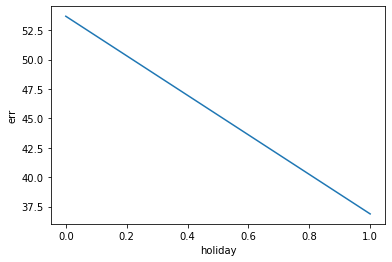

In [ ]:
group_by_day = final_data.groupby(by=['holiday']).mean()
sns.lineplot(x=group_by_day.index, y=group_by_day.err)

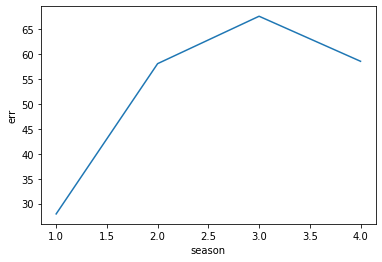

In [ ]:
group_by_day = final_data.groupby(by=['season']).mean()
sns.lineplot(x=group_by_day.index, y=group_by_day.err)

El sistema presenta mayor error en otoño y menor error en primavera.

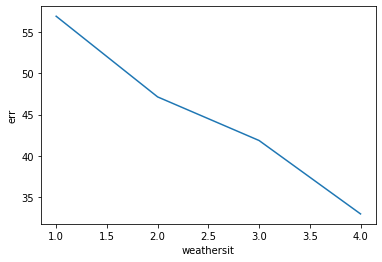

In [ ]:
group_by_day = final_data.groupby(by=['weathersit']).mean()
sns.lineplot(x=group_by_day.index, y=group_by_day.err)

En los dias despejados el sistema presenta mayores errores que en los demás estados climaticos. 

Claramente el sistema se equivoca mayoritariamente en los días no festivos, esto tiene sentido, pues el porcentaje de días festivos comparado con el porcentaje de días no festivos es mucho mayor.

### ¿Cómo mejorar el modelo?

Despues de análizar los resultados del módelo sería posible mejorar su comportamiento creando más caracteristicas historicas del comportamiento de la renta de bicicletas: Por ejemplo, si se usa la misma hora dos semanas antes, la misma hora tres semanas antes y más medias moviles. No se realiza una implementación nueva porque el tiempo de entrega de este taller no permite experimentar más con los datos finales. Otras mejores posibles serian eliminar caracteristicas que posiblemente causen ruido en el comportamiento final. Por ejemplo el weathersit no es un valor que no indique con muchas claridad que está pasando con el clima.

## Reporte final del error

Ahora recuerda entrenar el modelo con los mejores parámetros usando todos los datos de entrenamiento, calcular el error en los datos de prueba y calcula el error.  

Pro tip: grafica la serie de tiempo, usa colores distintos para los valores reales y las predicciones.

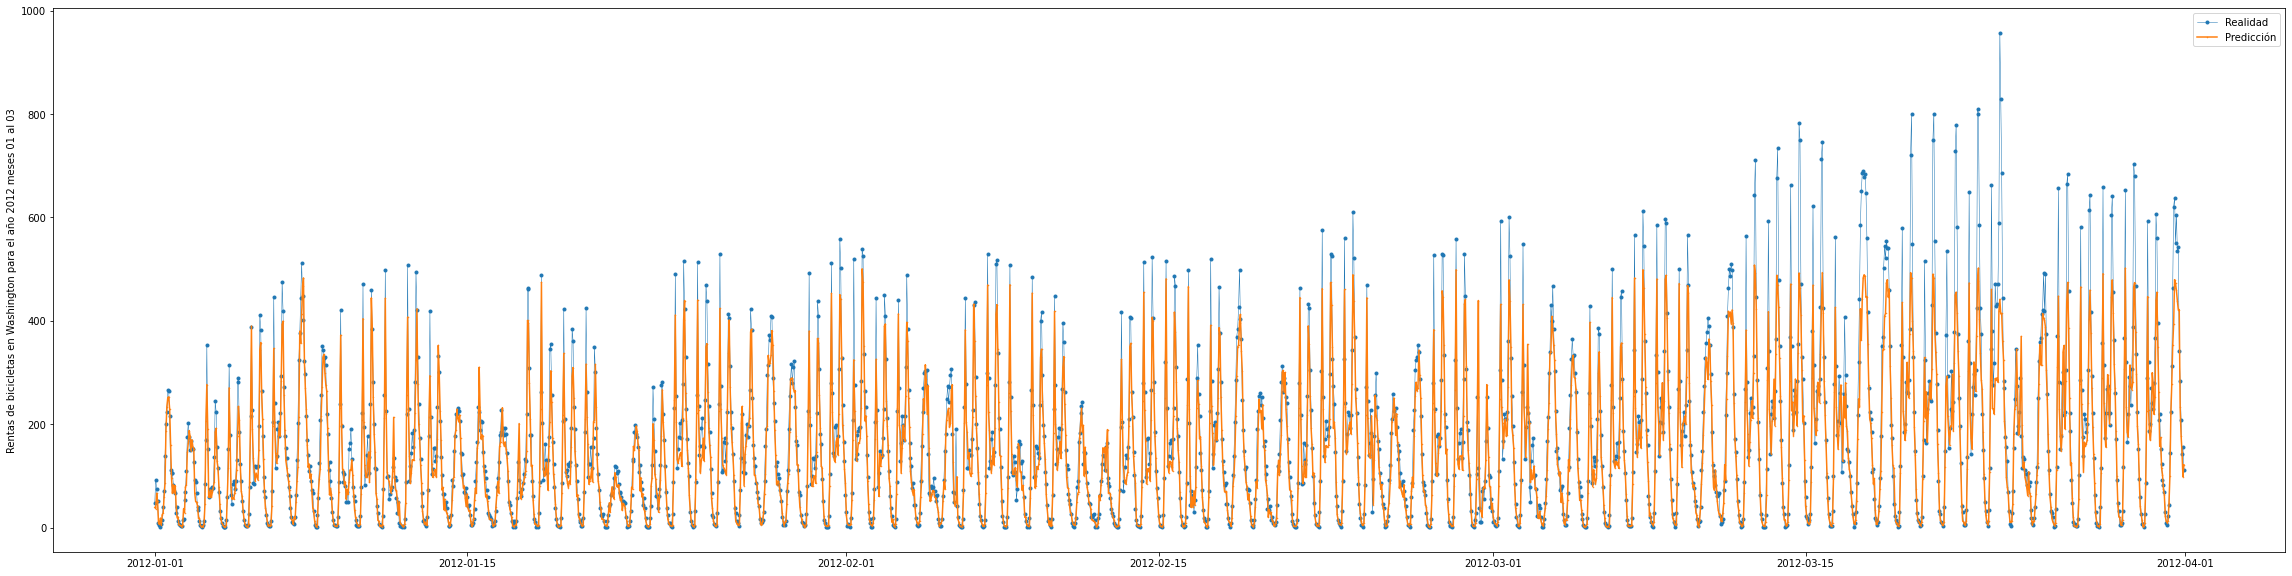

In [ ]:
start, end = '2012-01', '2012-03'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data.loc[start:end,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Realidad')
ax.plot(final_data.loc[start:end, 'y_pred'],
marker='.', markersize=1, linestyle='-', label='Predicción')
ax.set_ylabel('Rentas de bicicletas en Washington para el año 2012 meses 01 al 03')
ax.legend();

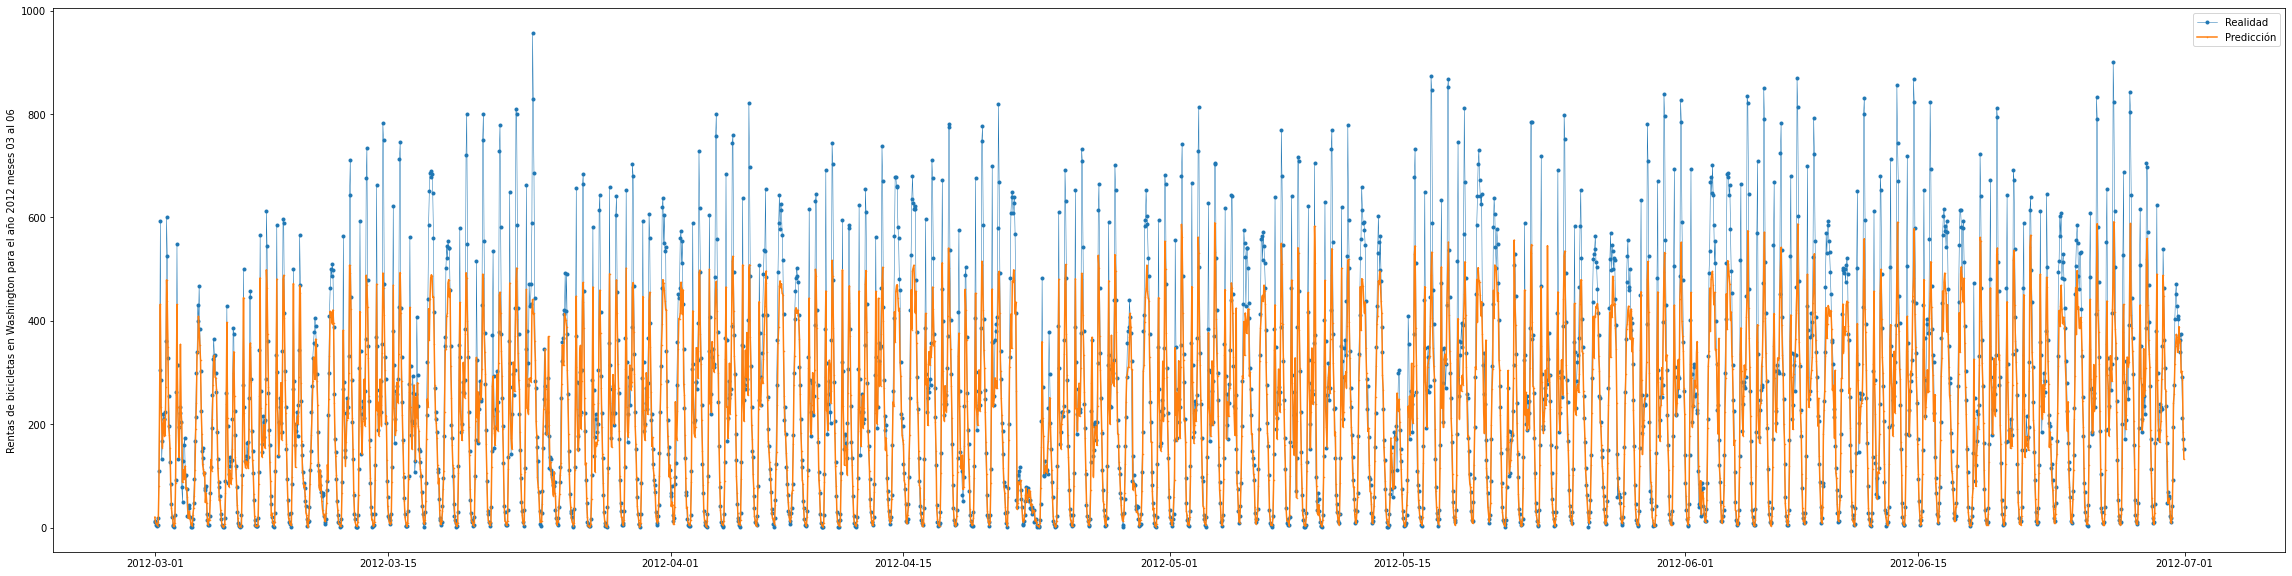

In [ ]:
start, end = '2012-03', '2012-06'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data.loc[start:end,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Realidad')
ax.plot(final_data.loc[start:end, 'y_pred'],
marker='.', markersize=1, linestyle='-', label='Predicción')
ax.set_ylabel('Rentas de bicicletas en Washington para el año 2012 meses 03 al 06')
ax.legend();

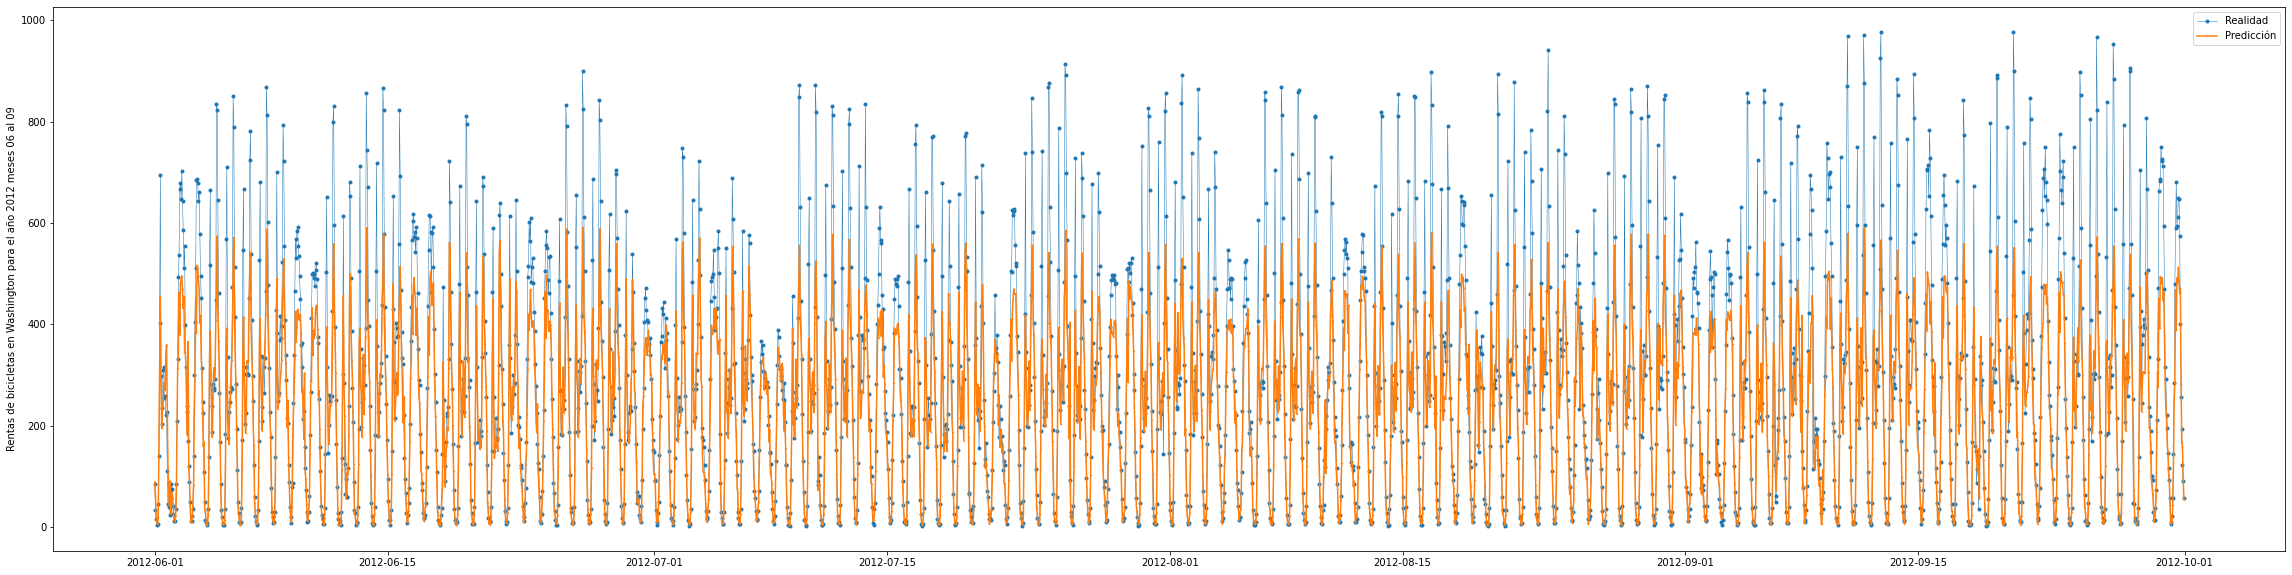

In [ ]:
start, end = '2012-06', '2012-09'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data.loc[start:end,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Realidad')
ax.plot(final_data.loc[start:end, 'y_pred'],
marker='.', markersize=1, linestyle='-', label='Predicción')
ax.set_ylabel('Rentas de bicicletas en Washington para el año 2012 meses 06 al 09')
ax.legend();

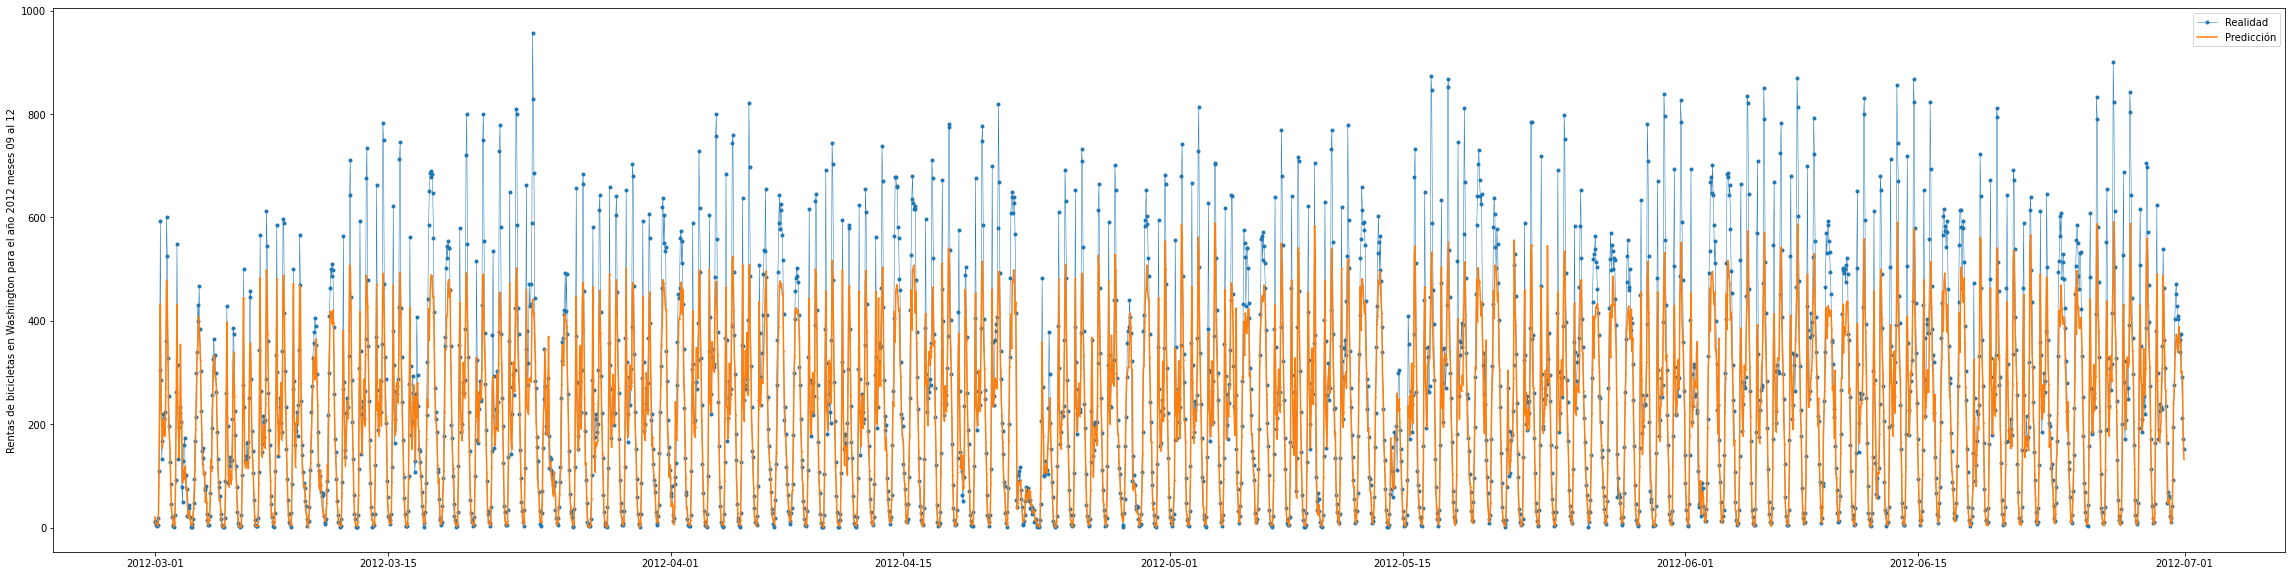

In [ ]:
start, end = '2012-03', '2012-06'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data.loc[start:end,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Realidad')
ax.plot(final_data.loc[start:end, 'y_pred'],
marker='.', markersize=1, linestyle='-', label='Predicción')
ax.set_ylabel('Rentas de bicicletas en Washington para el año 2012 meses 09 al 12')
ax.legend();

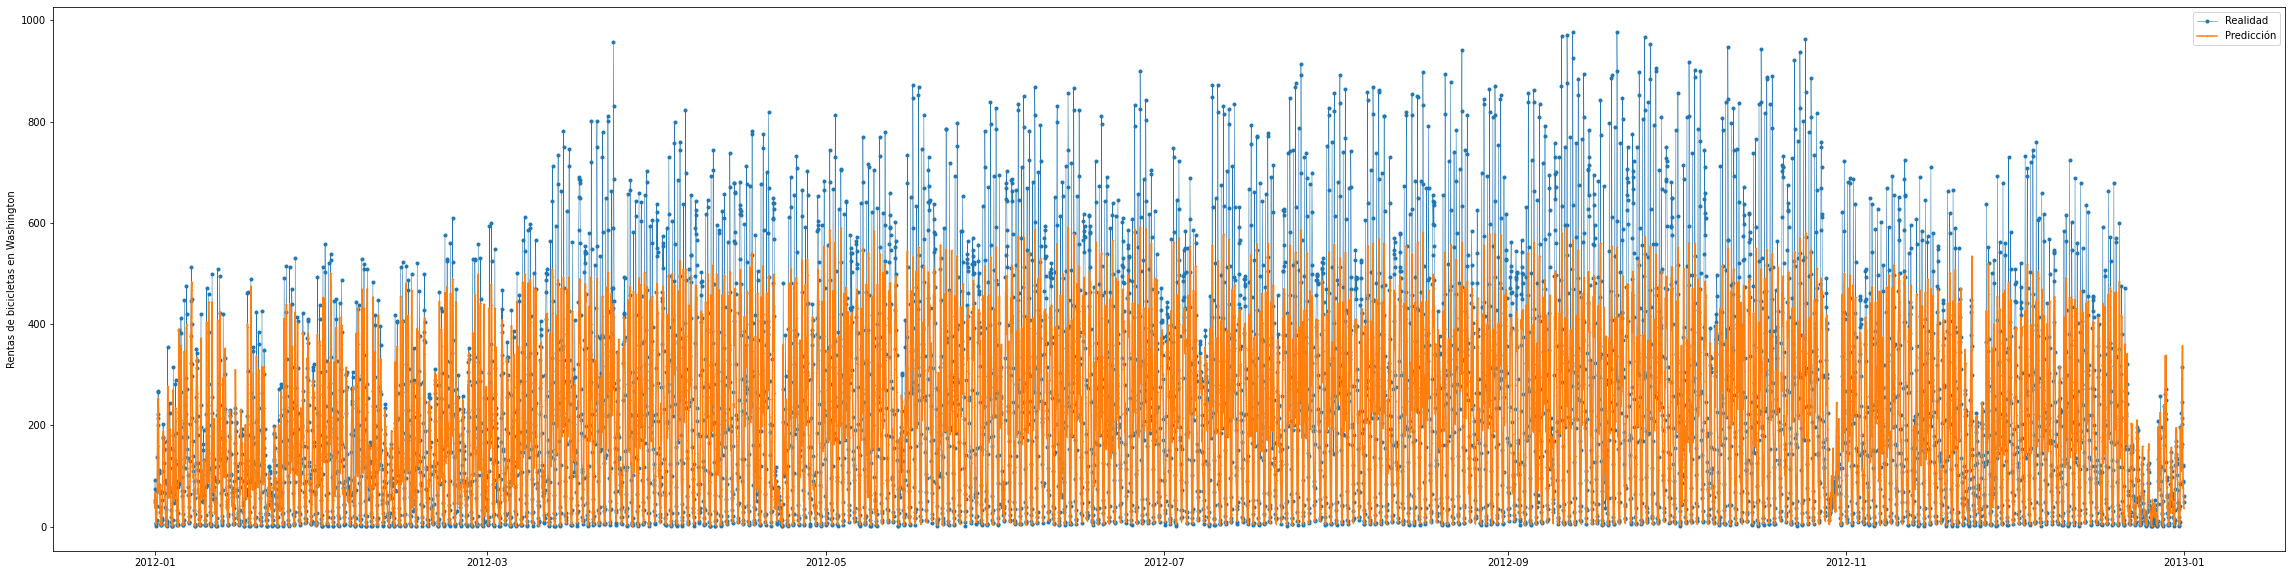

In [ ]:
start, end = '2011-01', '2012-12'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data.loc[start:end,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Realidad')
ax.plot(final_data.loc[start:end, 'y_pred'],
marker='.', markersize=1, linestyle='-', label='Predicción')
ax.set_ylabel('Rentas de bicicletas en Washington')
ax.legend();

## Predicciones

Llegó la hora de usar nuestro modelo para hacer predicciones. Predice unos cuantos meses después de la última fecha disponible en tu base de datos. Usa una visualización sugerida durante el reporte del error.

¿Tiene sentido lo que predices?

In [ ]:
final_data_pred = df_imp.copy()

three_month = final_data_pred.index[-1] + timedelta(weeks=12)

final_data_ = final_data_pred.reindex(pd.date_range(
        start=final_data_pred.index[0],
        end=three_month,
        freq='1H'
    )
)
final_data_.tail()

season  yr  mnth  hr  ...  windspeed  casual  registered  cnt
2013-03-25 19:00:00     NaN NaN   NaN NaN  ...        NaN     NaN         NaN  NaN
2013-03-25 20:00:00     NaN NaN   NaN NaN  ...        NaN     NaN         NaN  NaN
2013-03-25 21:00:00     NaN NaN   NaN NaN  ...        NaN     NaN         NaN  NaN
2013-03-25 22:00:00     NaN NaN   NaN NaN  ...        NaN     NaN         NaN  NaN
2013-03-25 23:00:00     NaN NaN   NaN NaN  ...        NaN     NaN         NaN  NaN

[5 rows x 15 columns]

In [ ]:
from random import seed
from random import randint
from datetime import date, datetime
import holidays

seed(1)

null_indexes = final_data_[final_data_.isna().any(axis=1)].index

Y = 2000
seasons = [(4, (date(Y,  1,  1),  date(Y,  3, 20))),
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),
           (4, (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

for index in null_indexes:
  final_data_.loc[index, ['hr', 'yr', 'mnth']] = (index.hour, int(index.year == 2012), index.month)
  final_data_.holiday.loc[index] = int(index in holidays.UnitedStates())
  final_data_.weekday.loc[index]  = index.dayofweek
  final_data_.workingday.loc[index]  = int(index.dayofweek in [0,1,2,3,4])
  final_data_.season.loc[index]  = get_season(index)
  final_data_.weathersit.loc[index]  = randint(1, 4)
  final_data_.temp.loc[index] = np.random.uniform(final_data_.temp.min(), final_data_.temp.max())
  final_data_.atemp.loc[index] = np.random.uniform(final_data_.atemp.min(), final_data_.atemp.max())
  final_data_.hum.loc[index] = np.random.uniform(final_data_.hum.min(), final_data_.hum.max())
  final_data_.windspeed.loc[index] = np.random.uniform(final_data_.windspeed.min(), final_data_.windspeed.max())
  ten_hours_before = index - timedelta(hours=10)
  final_data_.cnt.loc[index] = best_model.predict(final_data_[ten_hours_before:index])[-1]

In [ ]:
df_imp.head()

season  yr  mnth  hr  ...  windspeed  casual  registered   cnt
2011-01-01 00:00:00       1   0     1   0  ...        0.0     3.0        13.0  16.0
2011-01-01 01:00:00       1   0     1   1  ...        0.0     8.0        32.0  40.0
2011-01-01 02:00:00       1   0     1   2  ...        0.0     5.0        27.0  32.0
2011-01-01 03:00:00       1   0     1   3  ...        0.0     3.0        10.0  13.0
2011-01-01 04:00:00       1   0     1   4  ...        0.0     0.0         1.0   1.0

[5 rows x 15 columns]

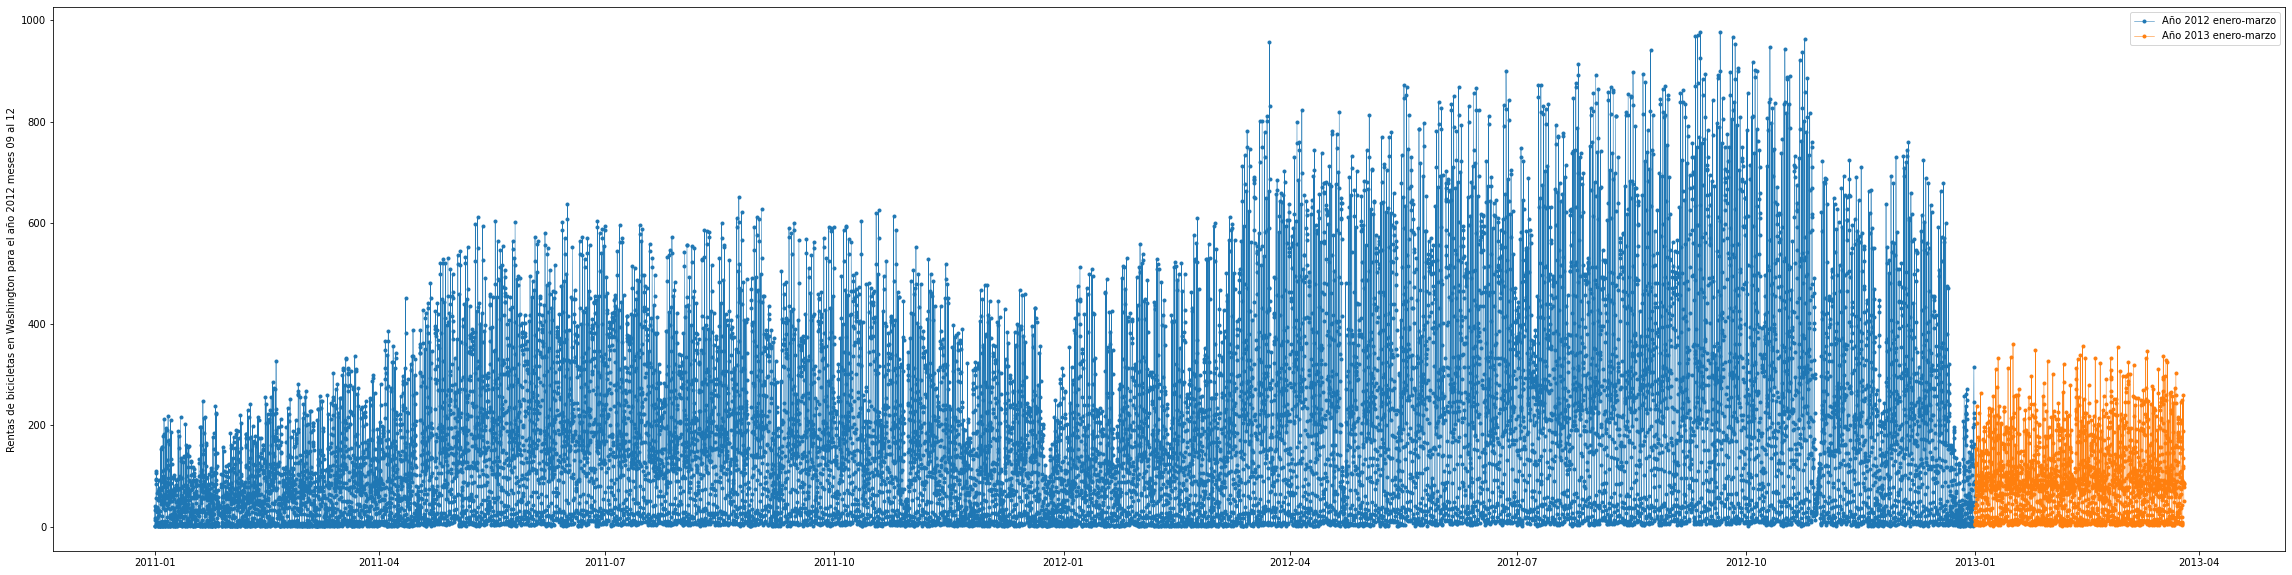

In [ ]:
startOld, endOld = '2011-01', '2012-12'
startNew, endNew = '2013-01', '2013-03'

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(final_data_.loc[startOld:endOld,'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Año 2012 enero-marzo')
ax.plot(final_data_.loc[startNew:endNew, 'cnt'],
marker='.', linestyle='-', linewidth=0.5, label='Año 2013 enero-marzo')
ax.set_ylabel('Rentas de bicicletas en Washington para el año 2012 meses 09 al 12')
ax.legend();

El resultado aunque no es presisamente muy bueno, nos permite  identificar que sigue un patrón cohortente con los datos historicos. Es bastante curioso como el sistema trata de promediar el valor de 2011 y el 2012 entre las mismas fechas para obtener un valor cohorente.

Felicitaciones por tu esfuerzo y llegar tan lejos! Te sugiero tener siempre presente el proceso que seguiste en este taller, algo muy parecido te hará falta en tu vida profesional.